## Simple Self-Attention Without Trainable Weights

In [1]:
import torch

In [2]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your
   [0.55, 0.87, 0.66], # journey
   [0.57, 0.85, 0.64], # starts
   [0.22, 0.58, 0.33], # with
   [0.77, 0.25, 0.10], # one
   [0.05, 0.80, 0.55]] # step
)

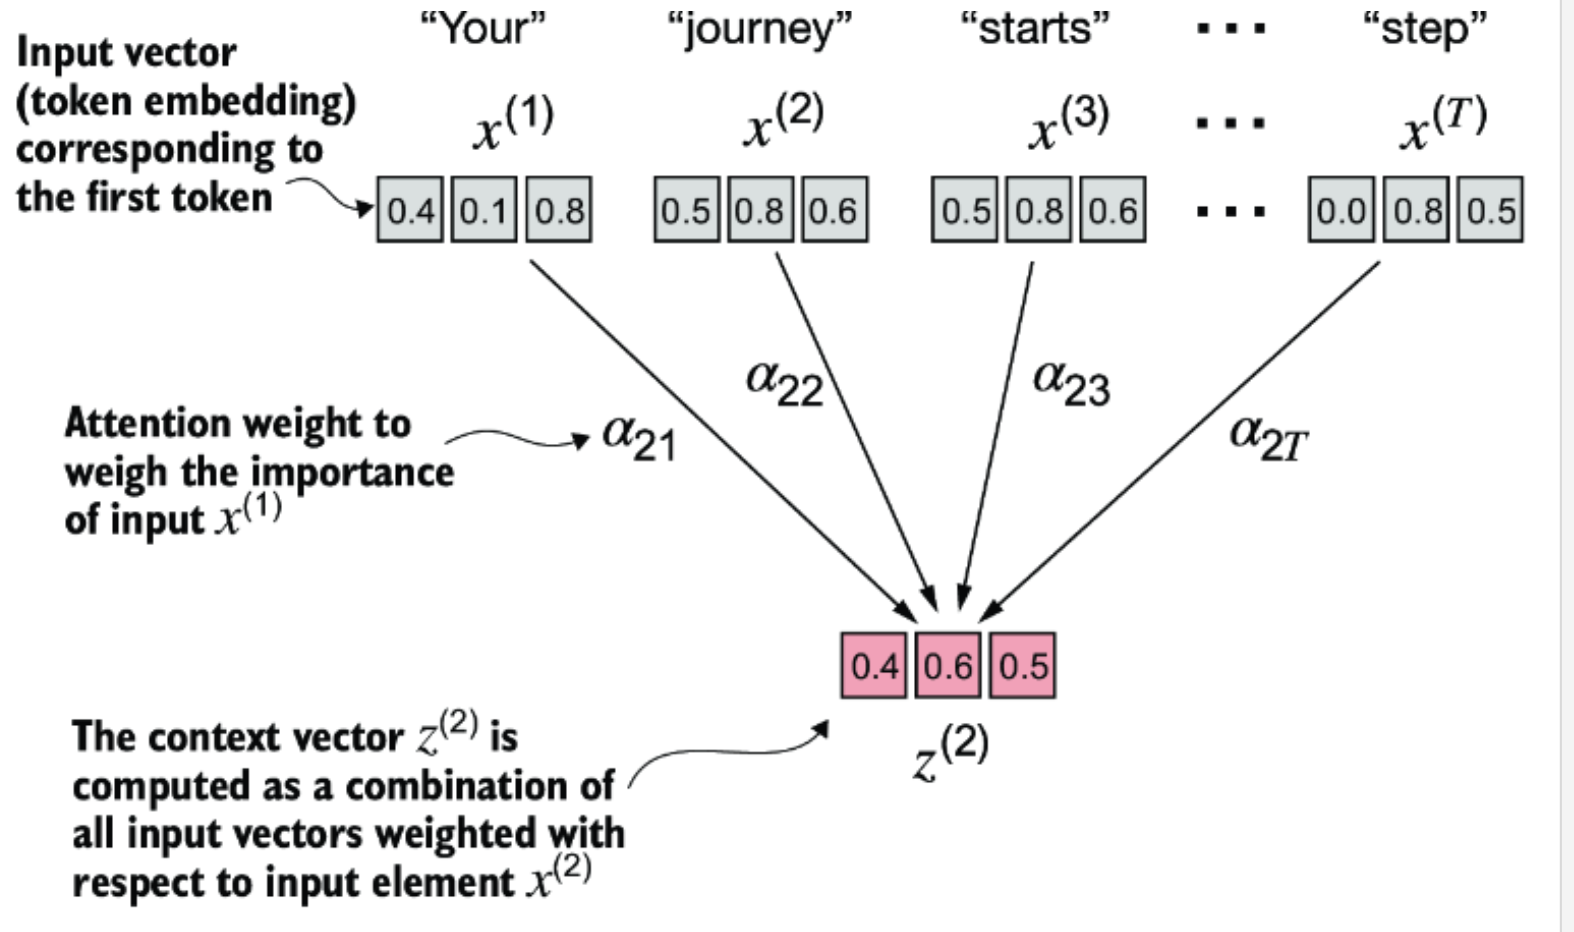


Credit:  [Build a Large Language Model (From Scratch)](https://livebook.manning.com/book/build-a-large-language-model-from-scratch/chapter-3/36)

In [4]:
query = inputs[1]
query

tensor([0.5500, 0.8700, 0.6600])

In [8]:
torch.empty(inputs.shape[0])

tensor([-4.1465e-01,  4.3988e-41,  1.4902e+22,  3.2310e-41,  4.4842e-44,
         0.0000e+00])

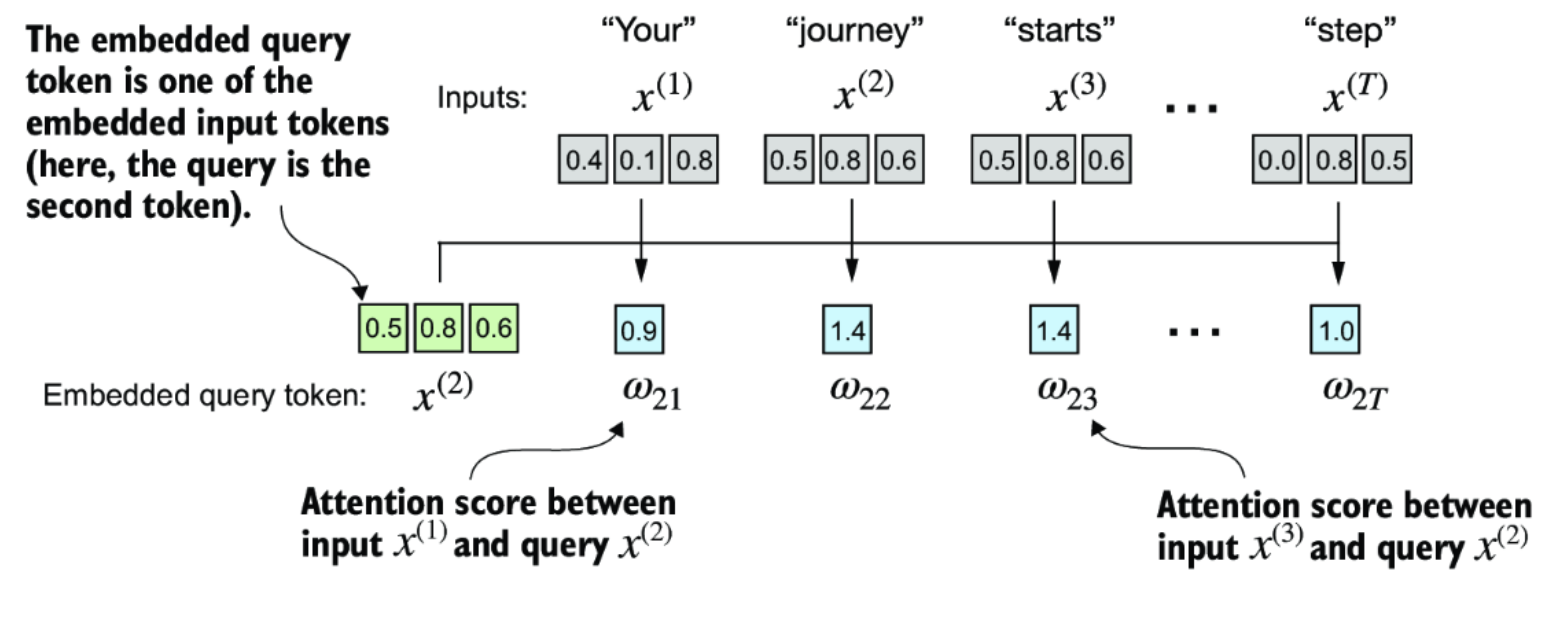

Credit:  [Build a Large Language Model (From Scratch)](https://livebook.manning.com/book/build-a-large-language-model-from-scratch/chapter-3/36)

By multiplying the query `x(2)` by each input token, we will get the attention score.

In [10]:
attention_score_2 = torch.empty(inputs.shape[0])

In [11]:
for i, x_i in enumerate(inputs):
  attention_score_2[i] = torch.dot(x_i, query)

print(attention_score_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


The dot product is a measure of similarity because it quantifies how closely two vectors are aligned. **The higher the dot product, the greater the similarity and attention score between two elements.**

We will now normalize each of the previously computed attention scores. The main goal of normalization is to obtain attention weights that add up to one. This normalization is a convention that helps with interpretation and training stability in LLMs.

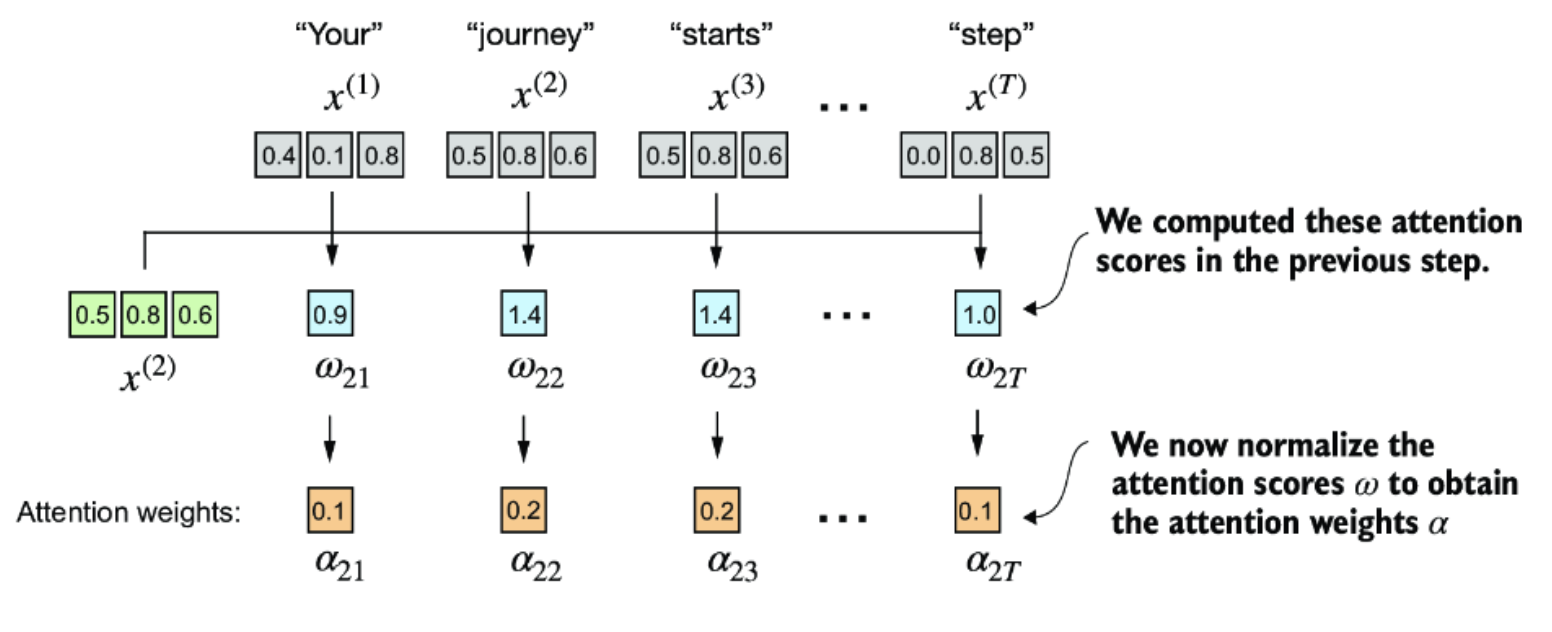

Credit:  [Build a Large Language Model (From Scratch)](https://livebook.manning.com/book/build-a-large-language-model-from-scratch/chapter-3/36)

In [12]:
attention_score_2_normalized = attention_score_2 / attention_score_2.sum()
attention_score_2_normalized

tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])

In [13]:
attention_score_2_normalized.sum()

tensor(1.0000)

In practice, the softmax function is more commonly used and recommended for normalization. This method is more effective at managing extreme values and provides better gradient properties during training. The following is a simple implementation of the softmax function for normalizing attention scores.

In [14]:
def softmax_fn(x):
  return torch.exp(x) / torch.exp(x).sum(dim=0)

In [16]:
attention_score_2_naive = softmax_fn(attention_score_2)
attention_score_2_naive

tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])

In [17]:
attention_score_2_naive.sum()

tensor(1.)

It need to be noted that this naive softmax implementation (`softmax_fn`) may experience numerical instability issues, such as overflow and underflow, when dealing with large or small input values. In practice, it is recommended to use the PyTorch implementation of softmax, which has been extensively optimized for performance:


In [18]:
attention_score_2 = torch.softmax(attention_score_2, dim=0)
attention_score_2

tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])

In [19]:
attention_score_2.sum()

tensor(1.)

In this case, it generates the same results as our previous`softmax_fn` function.

Now that we've computed the normalized attention weights, we're ready for the last step. The context vector `z(2)` is computed by multiplying the embedded input tokens, `x(i)`, by the corresponding attention weights and then adding the resulting vectors. Thus, context vector `z(2)` is the weighted sum of all input vectors, derived by multiplying each input vector by its corresponding attention weight:


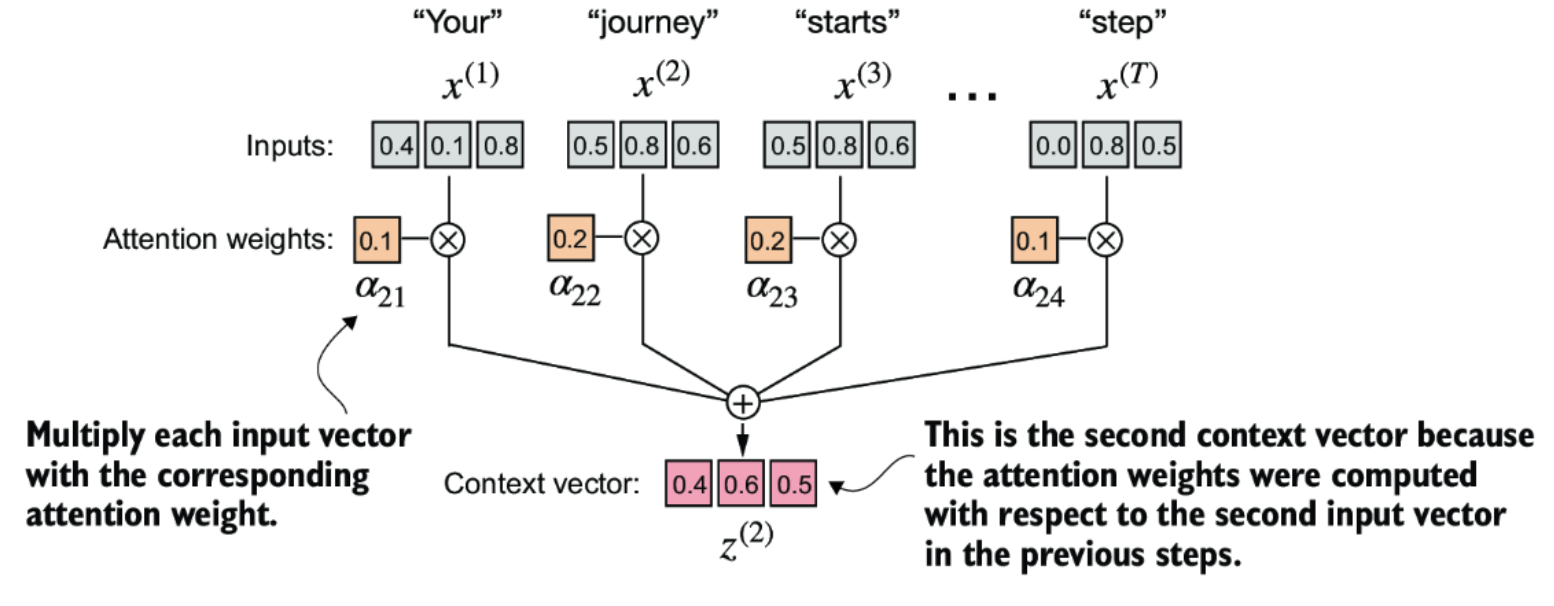

Credit:  [Build a Large Language Model (From Scratch)](https://livebook.manning.com/book/build-a-large-language-model-from-scratch/chapter-3/36)

In [20]:
query = inputs[1]
query

tensor([0.5500, 0.8700, 0.6600])

In [25]:
context_vector_2 = torch.zeros(query.shape)

for i, x_i in enumerate(inputs):
  context_vector_2 += (x_i * attention_score_2[i])

In [26]:
context_vector_2

tensor([0.4419, 0.6515, 0.5683])

## Computing Attention Weights for All Input Tokens


Let's expand this calculation to include attention weights and context vectors for all inputs.

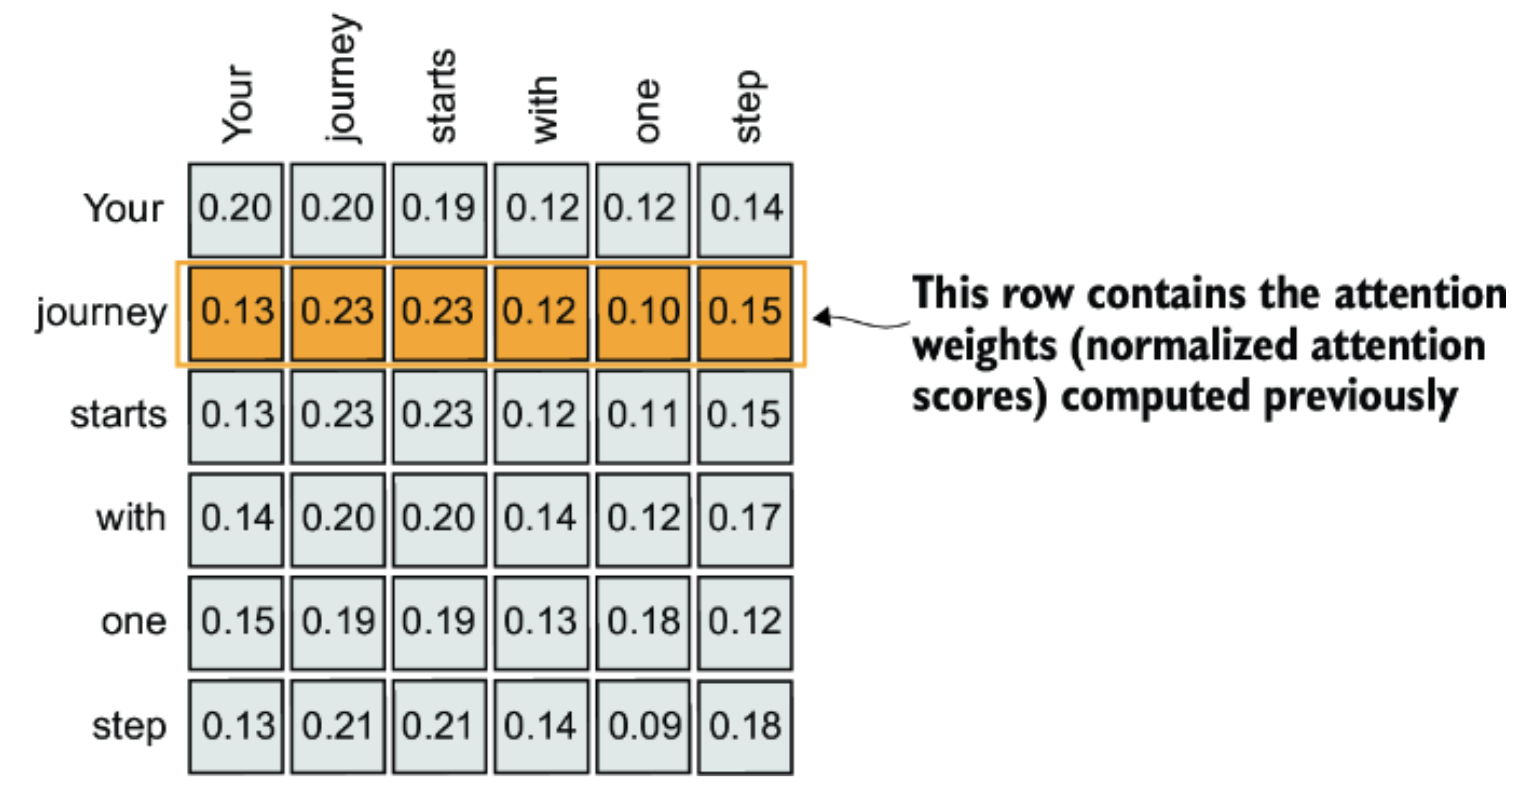

Credit:  [Build a Large Language Model (From Scratch)](https://livebook.manning.com/book/build-a-large-language-model-from-scratch/chapter-3/36)

In [30]:
input_dim = inputs.shape
input_dim

torch.Size([6, 3])

In [31]:
attention_scores = torch.empty(input_dim[0], input_dim[0])

In [32]:
for i, x_i in enumerate(inputs):
  for j, x_j in enumerate(inputs):
    attention_scores[i, j] = torch.dot(x_i, x_j)

In [33]:
attention_scores

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])

Each member of the tensor indicates the attention score between each pair of inputs.

We utilized **Python**'s for loop to compute the preceding attention score tensor. However, for loops are often slow, and we can get the same results using matrix multiplication:

In [34]:
attention_scores = inputs @ inputs.T
attention_scores

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])

We can clearly see that the outcomes are same to before.

Now we normalize each row so that the values add up to one.

In [35]:
attention_scores_normalized = torch.softmax(attention_scores, dim=-1)
attention_scores_normalized

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])

In [39]:
row_1_sum = sum([0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452])
row_1_sum

0.9999

In [40]:
attention_scores_normalized.sum(dim=-1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

### Computing Context Vectors

In [41]:
context_vectors = attention_scores_normalized @ inputs
context_vectors

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])

Each row in the resulting output tensor represents a three-dimensional context vector.

In [42]:
context_vector_2

tensor([0.4419, 0.6515, 0.5683])

Based on the results, we observe that the previously generated `context_vector_2` exactly matches the second row in the preceding tensor.
